 ########################################## PROBLEM 2 - Compute Ball Trajectory ##########################################


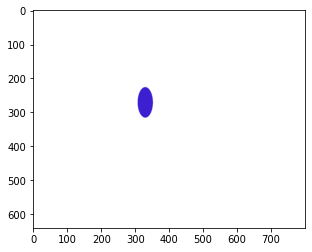

In [1]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max
import random
from helper_functions import *

print(" ########################################## PROBLEM 2 - Compute Ball Trajectory ##########################################")

path1 = './Data/Ball_travel_10fps.mp4'
path2 = './Data/Ball_travel_2_updated.mp4'

imgs = videoRead(path2)
plt.imshow(imgs[13])

In [2]:
# Least Squares: https://www.efunda.com/math/leastsquares/lstsqrmdcurve.cfm

locations, _ = getLocations(imgs)

x = locations[:,0].astype(np.float64)
Y = np.array(locations[:,1]).astype(np.int64)

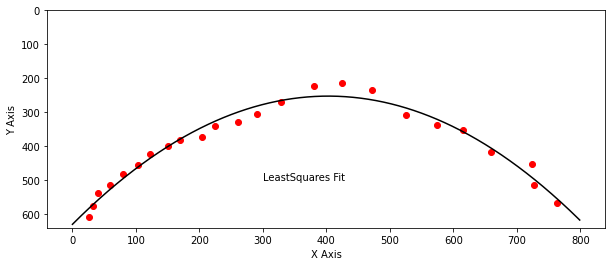

In [3]:
B = LeastSquares(x,Y)

x_ = np.linspace(0,800,800)    
y_pred = getModel(x_,B) 

fig = plt.figure(figsize=(10,4))
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.ylim([640, 0])
plt.scatter(x,Y,c='red')
plt.text(300,500,'LeastSquares Fit')
plt.plot(y_pred,'k')
plt.savefig('./Results/LeastSquaresFit.png')
plt.show()

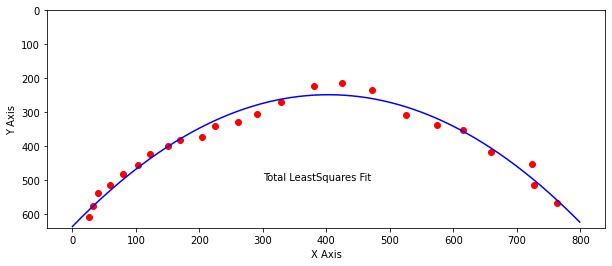

In [4]:
B = TotalLeastSquares(x,Y)
d = (B[0])*np.mean(x**2) + (B[1])*np.mean(x) + (B[2])*np.mean(Y)

x_ = np.linspace(0,800,800)
y_pred = getTLSModel(x_,B,d)

fig = plt.figure(figsize=(10,4))
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.ylim([640, 0])
plt.scatter(x,Y,c='red')
plt.text(300,500,'Total LeastSquares Fit')
plt.plot(y_pred,'b')
plt.savefig('./Results/TotalLeastSquaresFit.png')
plt.show()


Number of Iterations:  50
Max number of inliers: 17/24


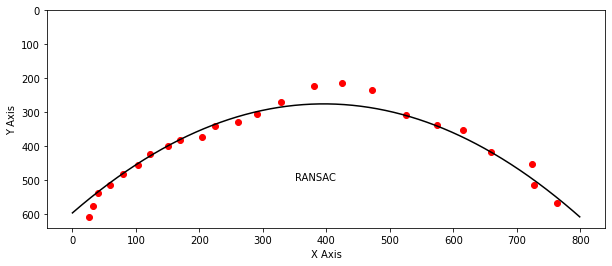

In [5]:

B,  predictions = Ransac(x,Y)

x_ = np.linspace(0,800,800)
y_pred = getModel(x_,B)

fig = plt.figure(figsize=(10,4))
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.ylim([640, 0])
plt.scatter(x,Y,c='red')
plt.text(350,500,'RANSAC')
plt.plot(y_pred,'k')
plt.savefig('./Results/RansacFit.png')
plt.show()


# HomoGraphy

In [37]:
def SVD(A):
    """ Reference: https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm 
        U is eigen vectors of A.AT
        V is eigen vectors of AT.A
        sig is a diagonal matrix with eigen values of ATA or AAT along the diagonals
        
        all are sorted in descending order of the eigen values
    """
    print(" Printing all steps involved in SVD: \n")
    # get eigen values and vectors of AAT
    eigenval,eigenvec=np.linalg.eig(np.dot(A,A.T))
    # make sure they are sorted in descending order
    sorted_idx = eigenval.argsort()[::-1] 
    eigenval = eigenval[sorted_idx]
 
    U = eigenvec[:,sorted_idx]
    print("####### U Matrix ####### \n")
    print(" U = Eigen Vectors of AAT (sorted in descending order) :\n ", np.around(eigenvec,3) )
    print("\n")
    # get the sigma Matrix component
    sig = np.zeros_like(A) # define a zero matrix of shape A
    
    sigval = eigenval**0.5 # get the diagonal matrix's values (no idea why i get negative values)
    diagMatrix = np.diag(sigval) # create diagonal matrix
    h,w = diagMatrix.shape[:2]
    sig[:h,:w] = diagMatrix # create the sigma matrix
    
    
    # get eigen values and vectors of ATA
    eigenval2,eigenvec = np.linalg.eig(np.dot(A.T,A))
    #make sure they are sorted in descending order
    sorted_idx = eigenval2.argsort()[::-1]
    V = eigenvec[:,sorted_idx] 
    print("####### V Matrix ####### \n")
    print(" V = Eigen Vectors of ATA (sorted in descending order) :\n ", np.around(eigenvec,3) )    
    print("\n")
    print("####### Sigma Matrix ####### \n")
    print(" Eigen Values of AAT :\n",np.around(eigenval,2))
    print("\n")
    print(" Eigen Values of ATA :\n", np.around(eigenval2,2))
    print("\n")
    print("S = sigma matrix diagonal values : \n ", np.around(sigval,2))
    print("\n")
    
    return U,sig,V.T


print(" ########################################## PROBLEM 3 - Compute Homography ##########################################")


X = np.array([5,150,150,5])
Y = np.array([5,5,150,150])

Xp = np.array([100,200,220,100])
Yp = np.array([100,80,80,200])

""" To compute Homography matrix:
    1) Compute the A matrix with 8x9 dimensions. Need to solve for Ax = 0 
    2) perform Singular Value decomposition on A matrix to find the solution x 
    3) reshape x into a 3x3 homography matrix
"""
############################ Generate A matrix ############################
startFlag=1

for (x,y,xp,yp) in zip(X,Y,Xp,Yp):

    if (startFlag == 1) :
        A = np.array([[-x,-y,-1,0,0,0, x*xp, y*xp,xp], [0,0,0,-x,-y,-1, x*yp, y*yp, yp]])
    else:
        tmp = np.array([[-x,-y,-1,0,0,0, x*xp, y*xp,xp], [0,0,0,-x,-y,-1, x*yp, y*yp, yp]])
        A = np.vstack((A, tmp))
        
    startFlag+=1    
    
    

print("The A matrix to be solved:")
print(A)    
print("\n")

U,S,Vt = SVD(A.astype(np.float32))


H = Vt[8,:]/Vt[8][8]
H = H.reshape(3,3)
print("The estimated Homography matrix is:  \n")
print(H)
print("\n")

H1 = cv2.getPerspectiveTransform(np.dstack((X,Y)).astype(np.float32), np.dstack((Xp,Yp)).astype(np.float32))
print("The estimated Homography matrix using opencv implementation:  \n")
print(H1)

 ########################################## PROBLEM 3 - Compute Homography ##########################################
The A matrix to be solved:
[[   -5    -5    -1     0     0     0   500   500   100]
 [    0     0     0    -5    -5    -1   500   500   100]
 [ -150    -5    -1     0     0     0 30000  1000   200]
 [    0     0     0  -150    -5    -1 12000   400    80]
 [ -150  -150    -1     0     0     0 33000 33000   220]
 [    0     0     0  -150  -150    -1 12000 12000    80]
 [   -5  -150    -1     0     0     0   500 15000   100]
 [    0     0     0    -5  -150    -1  1000 30000   200]]


 Printing all steps involved in SVD: 

####### U Matrix ####### 

 U = Eigen Vectors of AAT (sorted in descending order) :
  [[ 0.012  0.    -0.052 -0.466 -0.261 -0.066 -0.761 -0.359]
 [ 0.012  0.    -0.087 -0.459 -0.25  -0.087 -0.017  0.843]
 [ 0.359  0.655  0.013 -0.465  0.17   0.293  0.287 -0.171]
 [ 0.143  0.262 -0.445  0.136 -0.501 -0.588  0.256 -0.178]
 [ 0.775  0.023  0.408  0.285  0.03